<h1>Сборный проект<span class="tocSkip"></span></h1>

Интернет-магазин «Стримчик», продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Данные представлены до 2016 года.

<h3>Описание данных:<span class="tocSkip"></span></h3>

* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

In [3]:
try:
    data = pd.read_csv('datasets/games.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## Подготовка данных

### Переименование столбцов

In [7]:
data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [8]:
# Приводим столбцы к нижнему регистру
data.columns = data.columns.str.lower()

In [9]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Работа с пропусками

In [10]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

* В столбце name и genre имеется по два пропуска - удалим эти строки, т.к., в сравнении со всей выборкой, их кол-во очень мало;
* В столбце year_of_release - 269 пропусков - их тоже можно удалить, т.к. по сравнению с выборкой, имеющей свыше 16.000 строк, это мало.

In [11]:
data = data.dropna(subset=['genre', 'name', 'year_of_release'])

* В rating пропуски заполним пропуски "заглушками"

In [12]:
data['rating'] = data['rating'].fillna('не оценено')

In [13]:
data.isna().sum() #проверка, что пропуски удалились

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating                0
dtype: int64

In [14]:
data.query('user_score == "tbd"')['user_score'].count()

2376

Tbd, если дословно, "подлежит уточнению", т.е. оценки есть, но информация еще обрабыватается, поэтому в датасете их пока нет. Подобных значений относительно много, поэтому удалять эти строки не стоит, поэтому просто заменим на nan.

In [15]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

In [16]:
data.query('user_score == "tbd"')['user_score'].count()

0

Пропуски в названии и жанрах могли произойти по невнимательности или по какой-то ошибке при выгрузке данных (если смотреть, что это были за строки, то пропуски в жанрах находятся в тех же строках, где пропущены названия, скорее всего, это взаимосвязано). 

Год выпуска могли не знать, по случайности не внести или где-то могла быть тех.ошибка.

Со столбцами critic_score, user_score, и rating чуть сложнее в предположении - игры могли не учавстовать в оценивании, могли выйти раньше, чем подобное (присвоение играм рейтинга) получило распространение, отсутвуие информации про оценки и рейтинг, ну и случайные человеческие ошибки + ошибки при выгрузке.

### Изменение типов данных

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   object 
 10  rating           16444 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Изменим тип с float64 на int64 у  'year_of_release', т.к. вещественных годов быть не должно

In [18]:
data['year_of_release'] = data['year_of_release'].astype('int64')
data['user_score'] = data['user_score'].astype('float64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


### Расчет суммарных продаж

In [19]:
data['sum_sales'] = data['other_sales'] + data['eu_sales'] + data['jp_sales'] + data['na_sales']

In [20]:
data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,не оценено,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,не оценено,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,не оценено,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,не оценено,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,не оценено,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,не оценено,0.01


## Исследовательский анализ

### Количество игр по годам

In [21]:
games_per_year = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
games_per_year = games_per_year.rename(columns={'name': 'count_game'})
games_per_year

,count_game
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


,count_game
count,19.000000
mean,799.315789
std,356.140430
min,338.000000
25%,523.000000
50%,762.000000
75%,1071.000000
max,1427.000000


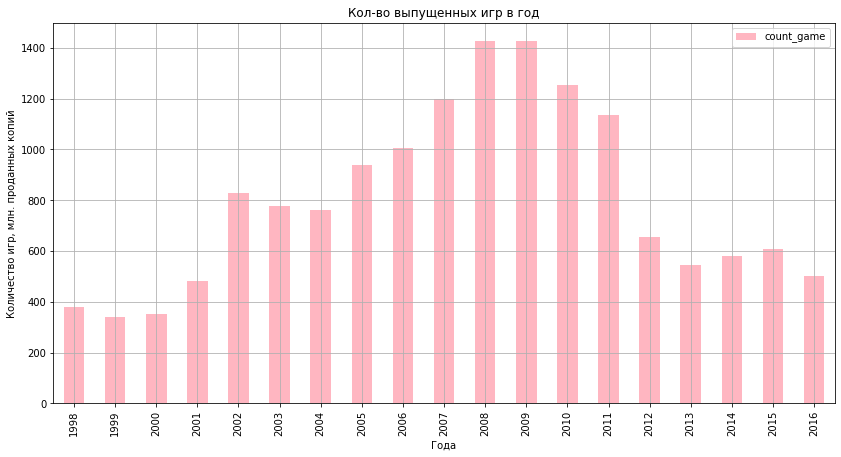

In [71]:
games_per_year.plot(kind='bar', grid=True, figsize=(14, 7), title='Кол-во выпущенных игр в год', color='lightpink');
plt.xlabel('Года');
plt.ylabel('Количество игр, млн. проданных копий');
games_per_year.describe()

По графику видно, что с 1980 по 1994 количество выпущенных игр прям очень маленькое, далее их кол-во увеличивается, но не быстро. Мне кажется, что если и рассматривать эти данные для анализа, то можно взять период с 1998 по 2016

In [23]:
games_per_year = games_per_year.query('count_game > 300')

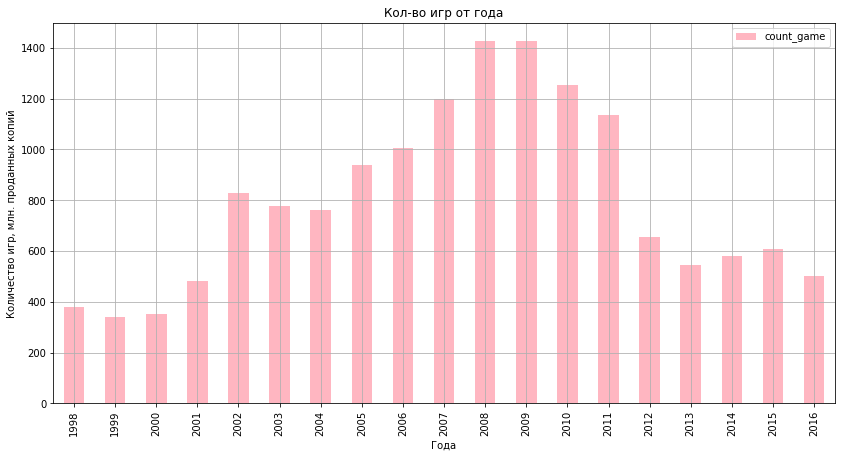

In [24]:
games_per_year.plot(kind='bar', grid=True, figsize=(14, 7), title='Кол-во игр от года', color='lightpink');
plt.xlabel('Года');
plt.ylabel('Количество игр, млн. проданных копий');

### Продажи по платформам

In [25]:
#Суммарные продажи по платформам 
sales_by_platform = data.pivot_table(index='platform', values='sum_sales', aggfunc='sum')
sales_by_platform = sales_by_platform.sort_values(by='sum_sales', ascending=False)
sales_by_platform

,sum_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


In [26]:
#возьмем срез по 10 платформам с наиболее крупными продажами
sales_by_platform_10 = sales_by_platform[:10]
sales_by_platform_10_index = sales_by_platform_10.index.to_list()
sales_by_platform_10

,sum_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


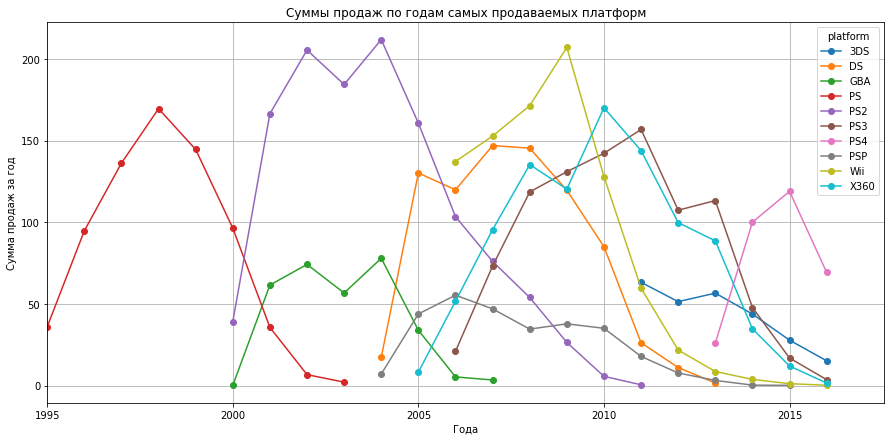

In [27]:
#Берем срез данных по 10 популрным платформам
popular_platform = data.query('platform in @sales_by_platform_10_index')

#Распредление по годам 
years_by_platform = popular_platform.pivot_table(index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum')
years_by_platform.plot(figsize=(15, 7), style='o-', grid=True);
plt.xlim(1995,);
plt.xlabel('Года');
plt.ylabel('Сумма продаж за год');
plt.title('Суммы продаж по годам самых продаваемых платформ');

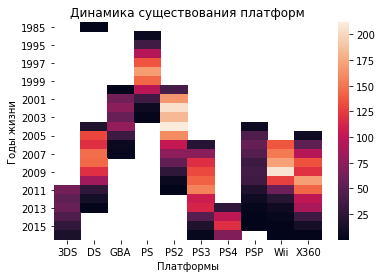

In [28]:
sns.heatmap(years_by_platform);
plt.xlabel('Платформы');
plt.ylabel('Годы жизни');
plt.title('Динамика существования платформ');

По графикам распредления видно, что, в среднем, каждая платформа живет окло 7-10 лет

Для дальнейшей работы решено было взять данные, начиная с 2013 года, чтобы данные были наиболее актуальными

In [29]:
data_new = data.query('year_of_release >= 2013').reset_index(drop=True)
data_new

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,не оценено,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,не оценено,14.60
4,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
2228,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,не оценено,0.01
2229,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,не оценено,0.01
2230,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,не оценено,0.01
2231,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,не оценено,0.01


In [30]:
#опредление платформ с наибольшими продажами в актуальных данных
sales_by_platform_new = data_new.pivot_table(index='platform', values='sum_sales', aggfunc='sum')
sales_by_platform_new = sales_by_platform_new.sort_values(by='sum_sales', ascending=False)
sales_by_platform_new

,sum_sales
platform,
PS4,314.14
PS3,181.43
XOne,159.32
3DS,143.25
X360,136.80
WiiU,64.63
PC,39.43
PSV,32.99
Wii,13.66


In [31]:
#возьмем срез по 10 платформам с наиболее крупными продажами в акутальных данных
sales_by_platform_new_10 = sales_by_platform_new[:10]
sales_by_platform_new_10_index = sales_by_platform_new_10.index.to_list()
sales_by_platform_new_10

,sum_sales
platform,
PS4,314.14
PS3,181.43
XOne,159.32
3DS,143.25
X360,136.80
WiiU,64.63
PC,39.43
PSV,32.99
Wii,13.66


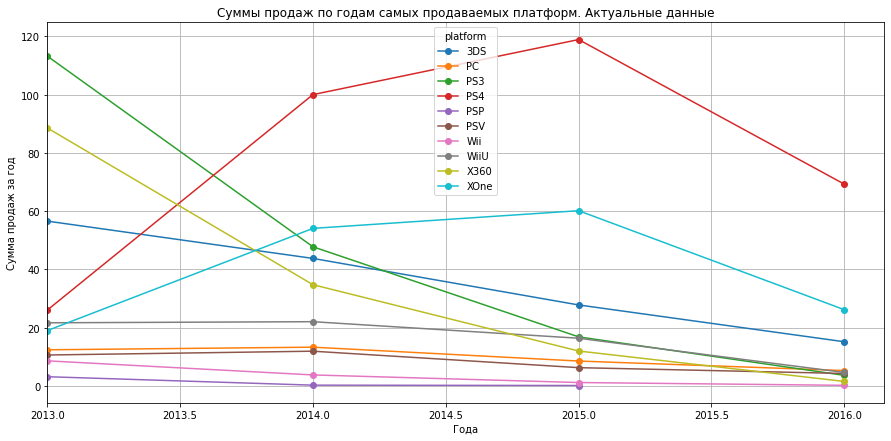

In [32]:
#Берем срез данных по 10 популрным платформам
popular_platform_new = data_new.query('platform in @sales_by_platform_new_10_index')

#Распредление по годам 
years_by_platform_new = popular_platform_new.pivot_table(index='year_of_release', columns='platform', values='sum_sales', aggfunc='sum')
years_by_platform_new.plot(figsize=(15, 7), style='o-', grid=True);
plt.xlim(2013,);
plt.xlabel('Года');
plt.ylabel('Сумма продаж за год');
plt.title('Суммы продаж по годам самых продаваемых платформ. Актуальные данные');

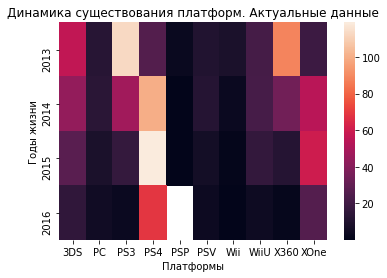

In [33]:
sns.heatmap(years_by_platform_new);
plt.xlabel('Платформы');
plt.ylabel('Годы жизни');
plt.title('Динамика существования платформ. Актуальные данные');

Лидируют по продажам PS4, PS3 и Xone. При этом на графиках видно, что у всех трех платформ, за выбранный период времени, наблюдается спад. PS4 имеет наиболее высокие показатели из всех трех, но с 2015 все равно идет спад. У PS3 идет достаточно резкий спад с 2013 года без каких-либо подъемов - ее поддержка прекратилась в 2016/2017 годах. У Xone был подъем с 2013 по 2015, но после динамика пошла на спад. При этом стоит учитывать, что за 2016 год данные могут быть неполными.

У всех остальных платформ как такового роста тоже не замечено. PC и PSV имеют низкую, но при этом стабильную динамику.

Построим «ящик с усами» по глобальным продажам игр в разбивке по платформам

platform,3DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
count,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,35.812500,9.857500,45.357500,78.535000,1.166667,8.247500,3.415000,16.157500,34.200000,39.830000
std,18.128338,3.701102,48.898675,40.567917,1.710010,3.596205,3.765355,8.129507,38.816131,20.313977
min,15.140000,5.250000,3.600000,25.990000,0.120000,4.250000,0.180000,4.600000,1.520000,18.960000
25%,24.620000,7.702500,13.515000,58.435000,0.180000,5.750000,0.900000,13.412500,9.350000,24.352500
50%,35.770000,10.450000,32.290000,84.625000,0.240000,8.420000,2.445000,19.000000,23.350000,40.110000
75%,46.962500,12.605000,64.132500,104.725000,1.690000,10.917500,4.960000,21.745000,48.200000,55.587500
max,56.570000,13.280000,113.250000,118.900000,3.140000,11.900000,8.590000,22.030000,88.580000,60.140000


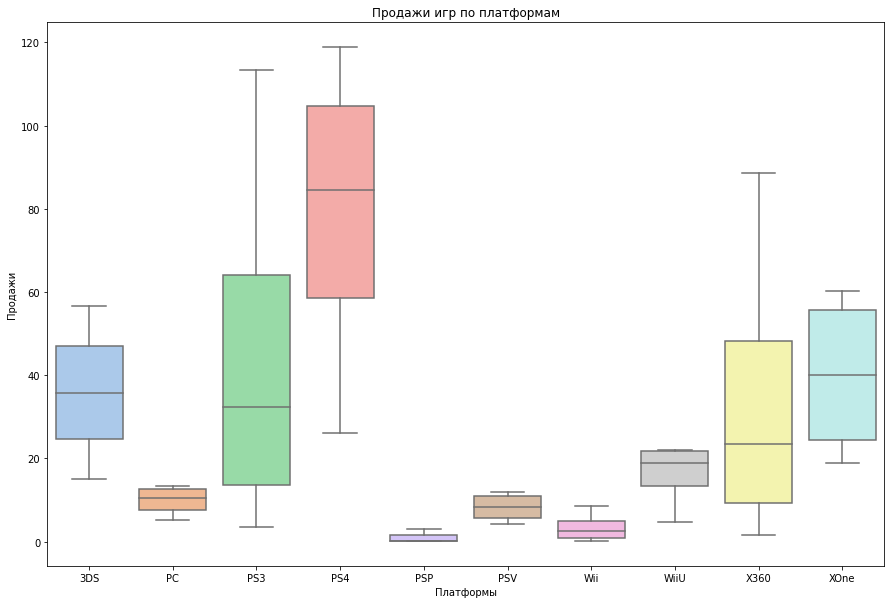

In [34]:
plt.figure(figsize=(15,10))
graph = sns.boxplot(palette='pastel', data=years_by_platform_new);
plt.xlabel('Платформы');
plt.ylabel('Продажи');
plt.title('Продажи игр по платформам');
years_by_platform_new.describe()

По этому графику видно, что наибольший и максимальный объем продаж у PS4. У PS3 объем меньше, но максимальное значение лежит недалеко от PS4. X360 имеет наименьшие (из топ-3) показатели. Медианное значние PS4 = 84.6, PS3 = 32.2, Xone = 40.1 - несмотря на то, что PS3 обгонят Xone по объему продаж, медианные значения у Xone Больше.

### Влияние отзывов пользователей и критиков на продажи по платформам

Рассмотрим влияние этих фактов на примере платформы PS4

In [35]:
platform_ps4 = data_new.query('platform == "PS4"')
grade_sales_ps4_user = platform_ps4.loc[:,['user_score','sum_sales']]
grade_sales_ps4_critic = platform_ps4.loc[:,['critic_score','sum_sales']]

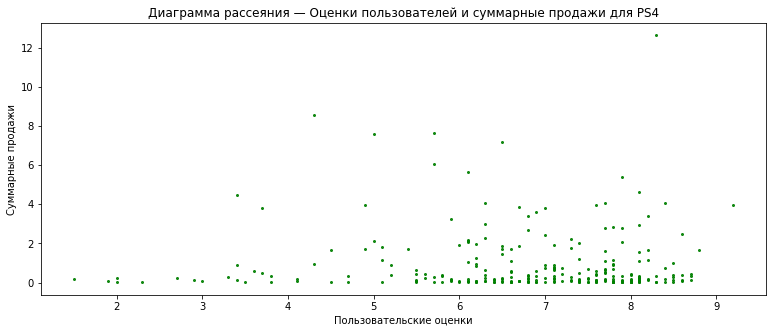

In [36]:
grade_sales_ps4_user.plot(kind='scatter', 
        y='sum_sales' , x='user_score', alpha=0.9, figsize=(13,5), c = 'g', s = 4)
plt.title('Диаграмма рассеяния — Оценки пользователей и суммарные продажи для PS4');
plt.xlabel('Пользовательские оценки');
plt.ylabel('Суммарные продажи');
#а эти точки можно как-то побольше сделать? Я как-то не нашла... 

In [37]:
grade_sales_ps4_user['user_score'].corr(grade_sales_ps4_user['sum_sales'])

-0.03195711020455641

Корреляция между суммарными продажами и оценками пользователей близка к 0, что говорит о слабой связи между этими двумя факторами. Отрицательный коэффициент корреляция говорит о том, что связь обратная

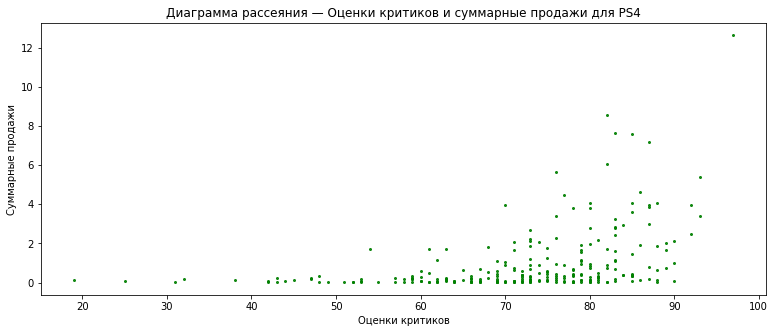

In [38]:
grade_sales_ps4_critic.plot(kind='scatter', 
        y='sum_sales' , x='critic_score', alpha=0.9, figsize=(13,5), c = 'g', s = 4)
plt.title('Диаграмма рассеяния — Оценки критиков и суммарные продажи для PS4');
plt.xlabel('Оценки критиков');
plt.ylabel('Суммарные продажи');

In [39]:
grade_sales_ps4_critic['critic_score'].corr(grade_sales_ps4_critic['sum_sales'])

0.40656790206178095

Корреляция между оценками критиков и суммарными продажами выше, но все равно связь остается слабой. Коэффициент пложительный => связь прямая

Рассмотрим платформу PS3

In [40]:
platform_ps3 = data_new.query('platform == "PS3"')
grade_sales_ps3_user = platform_ps3.loc[:,['user_score','sum_sales']]
grade_sales_ps3_critic = platform_ps3.loc[:,['critic_score','sum_sales']]

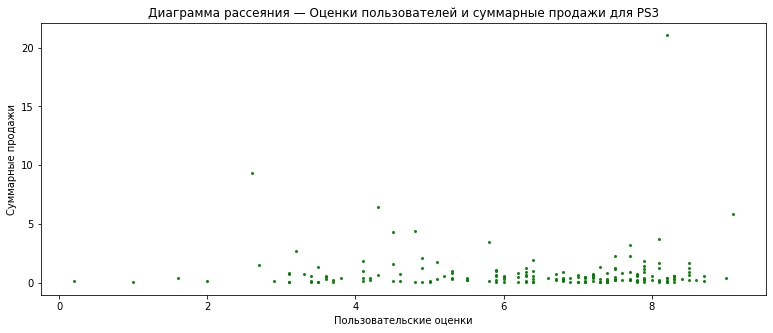

In [41]:
grade_sales_ps3_user.plot(kind='scatter', 
        y='sum_sales' , x='user_score', alpha=0.9, figsize=(13,5), c = 'g', s = 4)
plt.title('Диаграмма рассеяния — Оценки пользователей и суммарные продажи для PS3');
plt.xlabel('Пользовательские оценки');
plt.ylabel('Суммарные продажи');

In [42]:
grade_sales_ps3_user['user_score'].corr(grade_sales_ps3_user['sum_sales'])

0.0023944027357566907

Связь между оценкамми пользователей и суммарными продажами для PS3 также очень салабая, как и для PS4

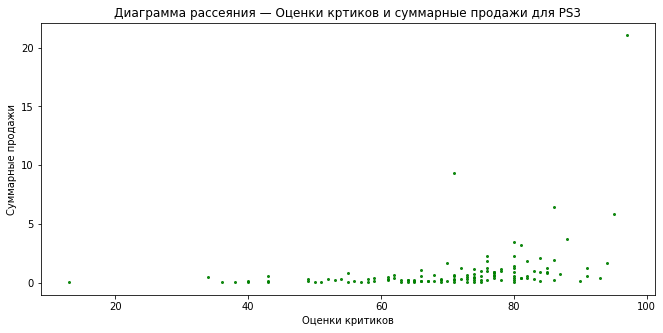

In [43]:
grade_sales_ps3_critic.plot(kind='scatter', 
        y='sum_sales' , x='critic_score', alpha=0.9, figsize=(11,5), c = 'g', s = 4)
plt.title('Диаграмма рассеяния — Оценки кртиков и суммарные продажи для PS3');
plt.xlabel('Оценки критиков');
plt.ylabel('Суммарные продажи');

In [44]:
grade_sales_ps3_critic['critic_score'].corr(grade_sales_ps3_critic['sum_sales'])

0.3342853393371919

Корреляция между оценками критиков и продажами выше, чем между продажами и пользовтельскими оценками для PS3, но связь все также слабая.

Рассмотрим платформу Xone

In [45]:
platform_xone = data_new.query('platform == "Xone"')
grade_sales_xone_user = platform_ps3.loc[:,['user_score','sum_sales']]
grade_sales_xone_critic = platform_ps3.loc[:,['critic_score','sum_sales']]

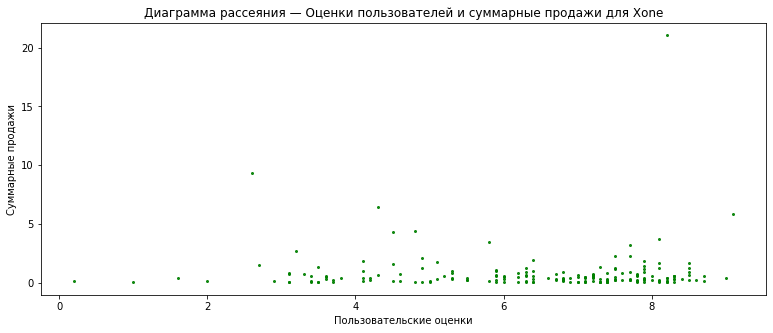

In [46]:
grade_sales_xone_user.plot(kind='scatter', 
        y='sum_sales' , x='user_score', alpha=0.9, figsize=(13,5), c = 'g', s = 4)
plt.title('Диаграмма рассеяния — Оценки пользователей и суммарные продажи для Xone');
plt.xlabel('Пользовательские оценки');
plt.ylabel('Суммарные продажи');

In [47]:
grade_sales_xone_user['user_score'].corr(grade_sales_xone_user['sum_sales'])

0.0023944027357566907

Коэфициент корреляции близок к 0 - связь между показателями очень слабая

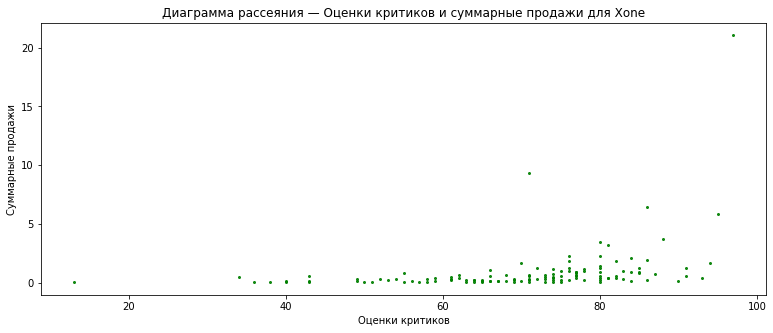

In [48]:
grade_sales_xone_critic.plot(kind='scatter', 
        y='sum_sales' , x='critic_score', alpha=0.9, figsize=(13,5), c = 'g', s = 4)
plt.title('Диаграмма рассеяния — Оценки критиков и суммарные продажи для Xone');
plt.xlabel('Оценки критиков');
plt.ylabel('Суммарные продажи');

In [49]:
grade_sales_xone_critic['critic_score'].corr(grade_sales_xone_critic['sum_sales'])

0.3342853393371919

Коэффицент корреляция больше, чем в предыдущем расчете, но свзязь все также слабая

В общем выводе можно сказать, что как таковой зависимости между оценками критиков/пользователей и суммарными продажами - нет. Между продажами и оценками критиков корреляция больше, чем между продажами и пользовательскими оценками, но значения коэфициента колеблются от 0,3 до 0,4, что говорит о слабой связи.

### Распредление по жанрам

In [50]:
data_new

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,не оценено,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,не оценено,14.60
4,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
2228,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,не оценено,0.01
2229,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,не оценено,0.01
2230,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,не оценено,0.01
2231,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,не оценено,0.01


In [51]:
#опредление платформ с наибольшими продажами в актуальных данных
games_by_genre = data_new.pivot_table(index='genre', values='sum_sales', aggfunc='sum')
games_by_genre = games_by_genre.sort_values(by='sum_sales', ascending=False)
games_by_genre

,sum_sales
genre,
Action,321.87
Shooter,232.98
Sports,150.65
Role-Playing,145.89
Misc,62.82
Platform,42.63
Racing,39.89
Fighting,35.31
Adventure,23.64


По суммарным продажам в ТОП-3 входят игры с жанрами: экшен, шутер и спортивные.

In [52]:
games_by_genre_median = data_new.pivot_table(index='genre', values='sum_sales', aggfunc='median')
games_by_genre_median = games_by_genre_median.sort_values(by='sum_sales', ascending=False)
games_by_genre_median_index = games_by_genre_median.index.to_list()
games_by_genre_median

,sum_sales
genre,
Shooter,0.450
Sports,0.240
Platform,0.225
Fighting,0.125
Role-Playing,0.125
Racing,0.120
Action,0.110
Simulation,0.100
Misc,0.100


По медианным данным ТОП-3 занимают жанры: шутеры, спортивные и платформеры. Жанр экшен занимает вообще 7 место

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,0.131250,0.028750,0.117500,0.141250,0.353750,0.051250,0.177500,0.128750,0.541250,0.112500,0.267500,0.088750
std,0.082702,0.008539,0.031225,0.068602,0.344755,0.037053,0.120381,0.034731,0.312313,0.071705,0.174236,0.067869
min,0.050000,0.020000,0.085000,0.040000,0.100000,0.010000,0.050000,0.105000,0.240000,0.025000,0.120000,0.045000
25%,0.065000,0.023750,0.096250,0.130000,0.100000,0.036250,0.125000,0.108750,0.315000,0.085000,0.120000,0.056250
50%,0.135000,0.027500,0.115000,0.167500,0.242500,0.047500,0.160000,0.115000,0.500000,0.112500,0.245000,0.060000
75%,0.201250,0.032500,0.136250,0.178750,0.496250,0.062500,0.212500,0.135000,0.726250,0.140000,0.392500,0.092500
max,0.205000,0.040000,0.155000,0.190000,0.830000,0.100000,0.340000,0.180000,0.925000,0.200000,0.460000,0.190000


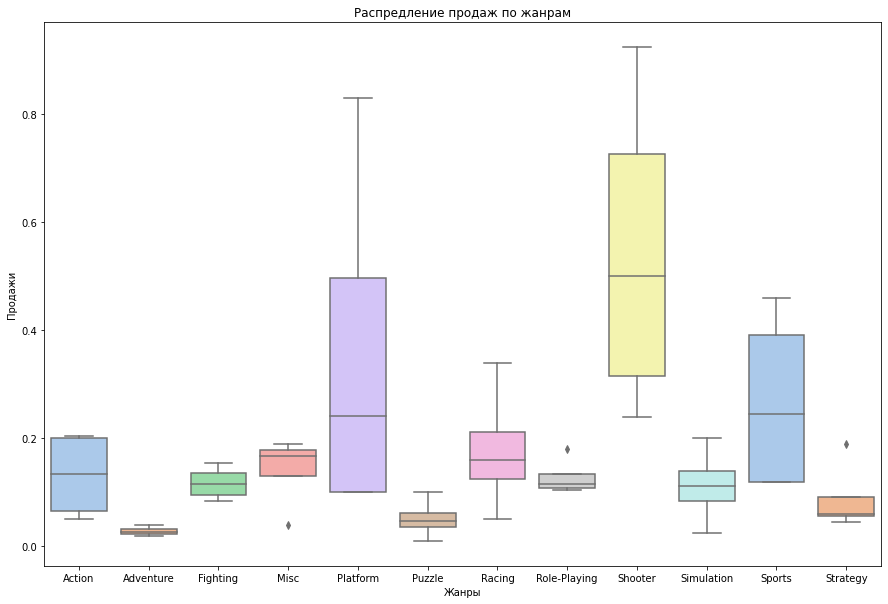

In [53]:
games_by_genre_2 = data_new.query('genre in @games_by_genre_median_index')

#Распредление по годам 
games_by_genre_years = games_by_genre_2.pivot_table(index='year_of_release', columns='genre', values='sum_sales', aggfunc='median')
plt.figure(figsize=(15,10))
graph = sns.boxplot(palette='pastel', data=games_by_genre_years);
plt.xlabel('Жанры');
plt.ylabel('Продажи');
plt.title('Распредление продаж по жанрам');
games_by_genre_years.describe()

По ящику с усами в некоторых жанрах видны выбросы

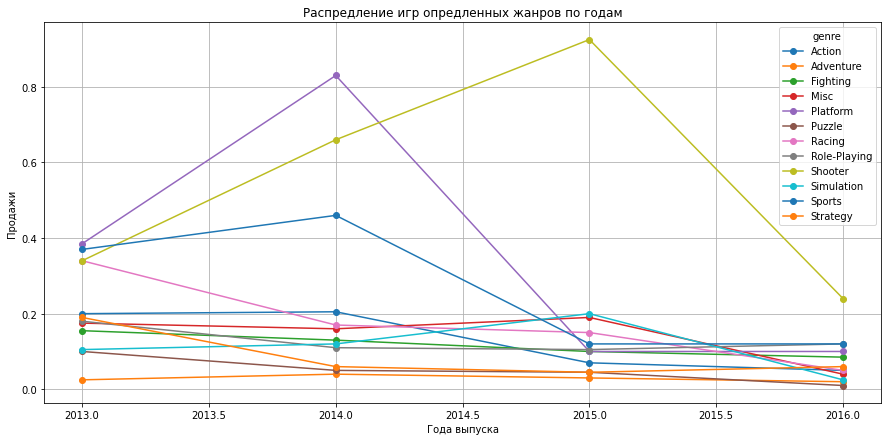

In [54]:
games_by_genre_years.plot(figsize=(15, 7), style='o-', grid=True);
plt.xlabel('Года выпуска');
plt.ylabel('Продажи');
plt.title('Распредление игр опредленных жанров по годам');

В общем выводе можно сказать, что жанры action и shooter популярны как при суммарных значениях, так и при медианных. При расчете суммарных продаж в топ-3 входит жанр sports, platform занимает 6 место. А при расчете медианных продаж в топ-3 входит platform, а sports занимает 8 место. Так что результаты разнятся в зависимости от способоа расчета.

Самим низкопродоваемыми жанрами являются: при суммарных продажах - puzzle, при медианных - adventure.

## Портреты пользователей по регионам

### Северная Америка

In [55]:
data_new

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,не оценено,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,не оценено,14.60
4,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
2228,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,не оценено,0.01
2229,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,не оценено,0.01
2230,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,не оценено,0.01
2231,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,не оценено,0.01


Рассмотрим популярные платформы

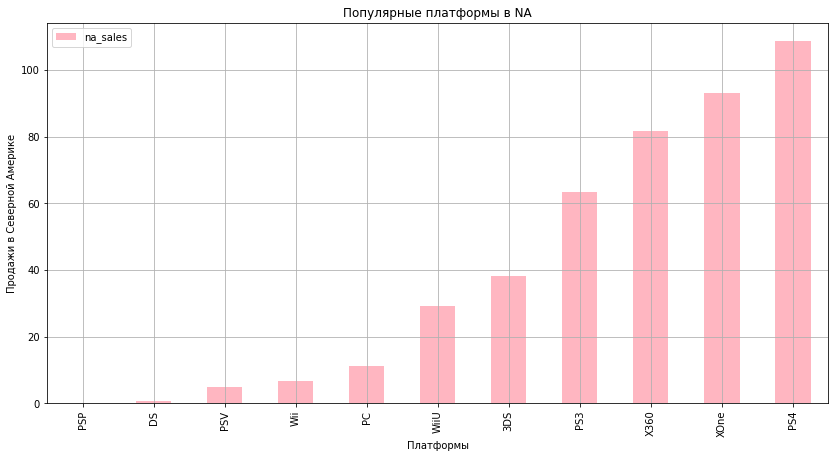

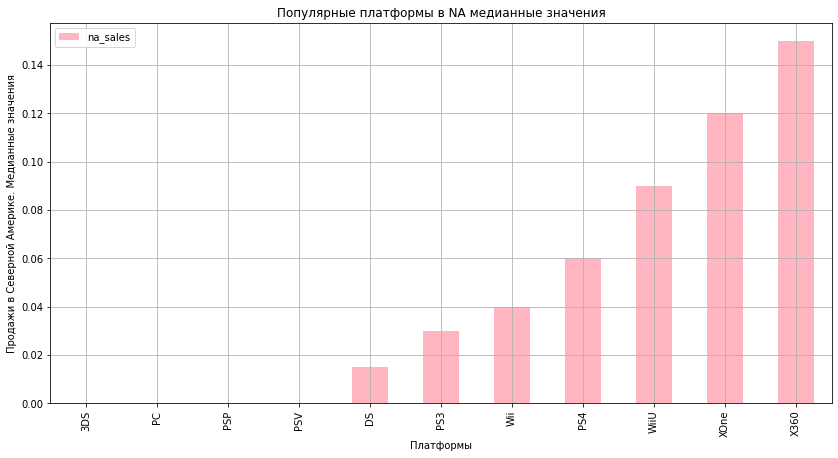

In [73]:
na_user_platform = data_new.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales')
na_user_platform_median = data_new.pivot_table(index='platform', values='na_sales', aggfunc='median').sort_values(by='na_sales')
na_user_platform.plot(kind='bar', grid=True, figsize=(14, 7), title='Популярные платформы в NA', color='lightpink');
plt.xlabel('Платформы');
plt.ylabel('Продажи в Северной Америке');
plt.show()

na_user_platform_median.plot(kind='bar', grid=True, figsize=(14, 7), 
                             title='Популярные платформы в NA медианные значения', color='lightpink');
plt.xlabel('Платформы');
plt.ylabel('Продажи в Северной Америке. Медианные значения');

Рассмотрим популярные жанры

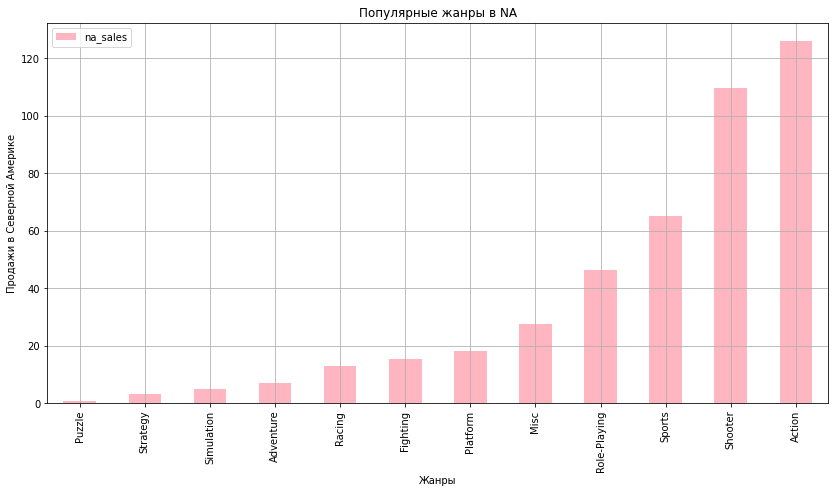

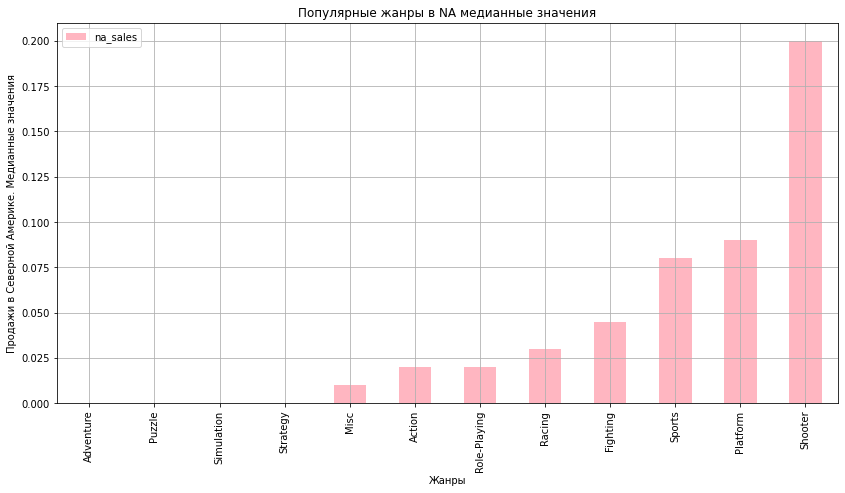

In [72]:
na_user_platform = data_new.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales')
na_user_platform_median = data_new.pivot_table(index='genre', values='na_sales', aggfunc='median').sort_values(by='na_sales')
na_user_platform.plot(kind='bar', grid=True, figsize=(14, 7), title='Популярные жанры в NA', color='lightpink');
plt.xlabel('Жанры');
plt.ylabel('Продажи в Северной Америке');
plt.show()

na_user_platform_median.plot(kind='bar', grid=True, figsize=(14, 7),
                             title='Популярные жанры в NA медианные значения', color='lightpink');
plt.xlabel('Жанры');
plt.ylabel('Продажи в Северной Америке. Медианные значения');

Рассмотрим влияние рейтинг ESRB

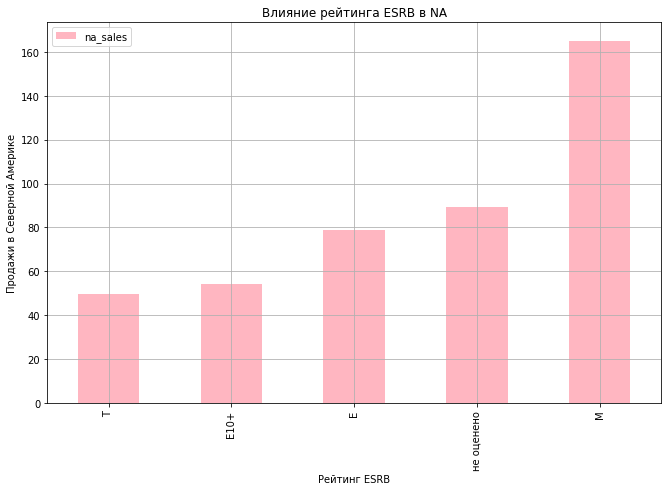

In [74]:
na_user_platform = data_new.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales')
na_user_platform.plot(kind='bar', grid=True, figsize=(11, 7), title='Влияние рейтинга ESRB в NA', color='lightpink');
plt.xlabel('Рейтинг ESRB');
plt.ylabel('Продажи в Северной Америке');

Рассматривая популярные платформы в Северной Америке, в ТОП-5 можно выделить следующие: PS4, Xone, X360, PS3, 3Ds. Возможно, в Америке имеют бОльшую популярность первые 4 платформы, т.к. PlayStation и Xbox являются американскими разработками. Но если рассматривать медианные значения, то в топ-5 буду выходить: X360, Xone, WiiU, Ps4, Wii. 

Касаемо жанров, можно выделить следующие 5 наиболее популярных - action, shooter, sports, role-playing, misc. Shooter и action имеют не очень большую разницу между собой, в то время как жанр sports заметно отстает от них двоих. Видимо, американские пользователи предпочитают игры, наполненные стрельбой, боями, побегами и прочим, больше, чем различные симуляторы, стратегии и другие. Но при этом, если рассмтривать медианные згачения, больше всего прибыли приносят шутеры.

В Северной Америке больше всего продаж пришлось на игры с рейтингом М (17 лет и старше).На втором месте игры, у которых рейтинга пока/еще нет (возможно, эти игры еще не оценило американское рейтинговое агенство или не обновилась информация). 
Другие возростные рейтинги:
* E - подходит для всех возрастных категорий;
* E10+ - подходит для лиц старше 10 лет;
* T - подходит для лиц старше 13 лет.

### Европа

Рассмотрим популярные платформы

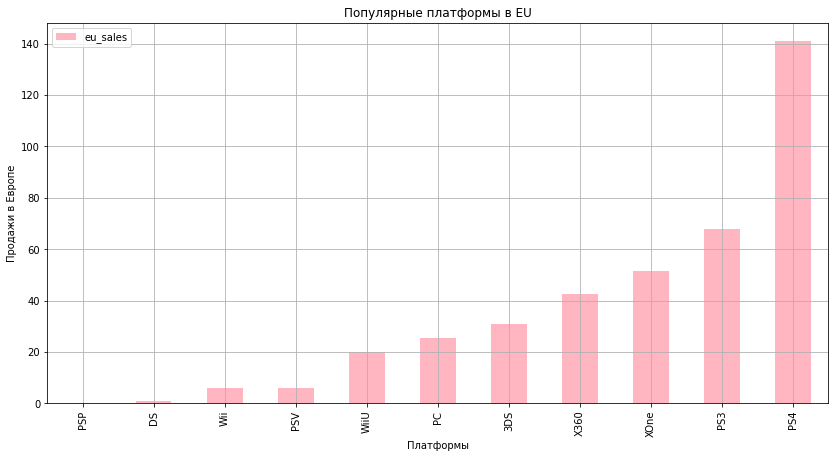

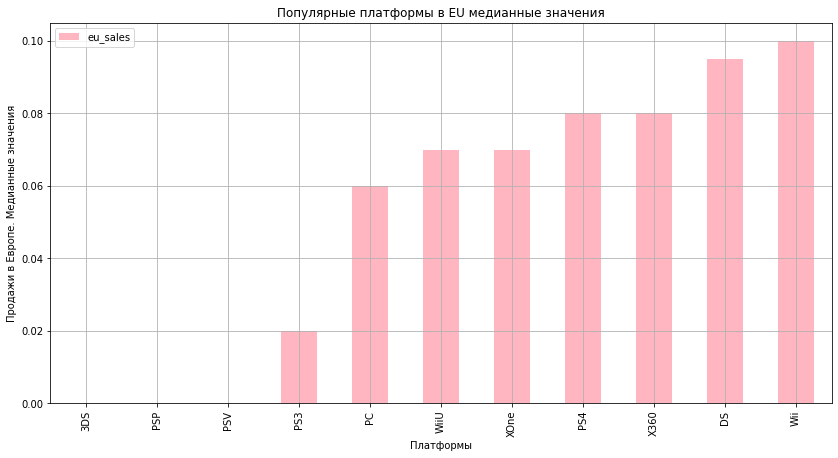

In [75]:
eu_user_platform = data_new.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales')
eu_user_platform_median = data_new.pivot_table(index='platform', values='eu_sales', aggfunc='median').sort_values(by='eu_sales')
eu_user_platform.plot(kind='bar', grid=True, figsize=(14, 7), title='Популярные платформы в EU', color='lightpink');
plt.xlabel('Платформы');
plt.ylabel('Продажи в Европе');
plt.show()

eu_user_platform_median.plot(kind='bar', grid=True, figsize=(14, 7), 
                             title='Популярные платформы в EU медианные значения', color='lightpink');
plt.xlabel('Платформы');
plt.ylabel('Продажи в Европе. Медианные значения');

Рассмотрим популярные жанры

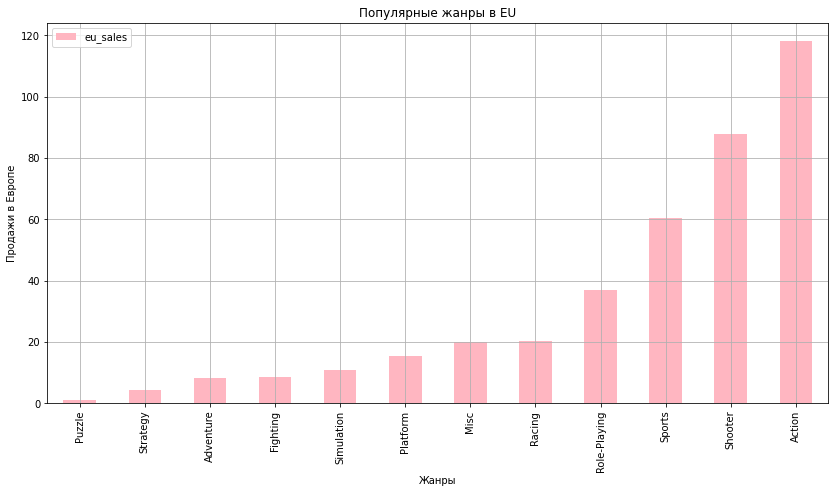

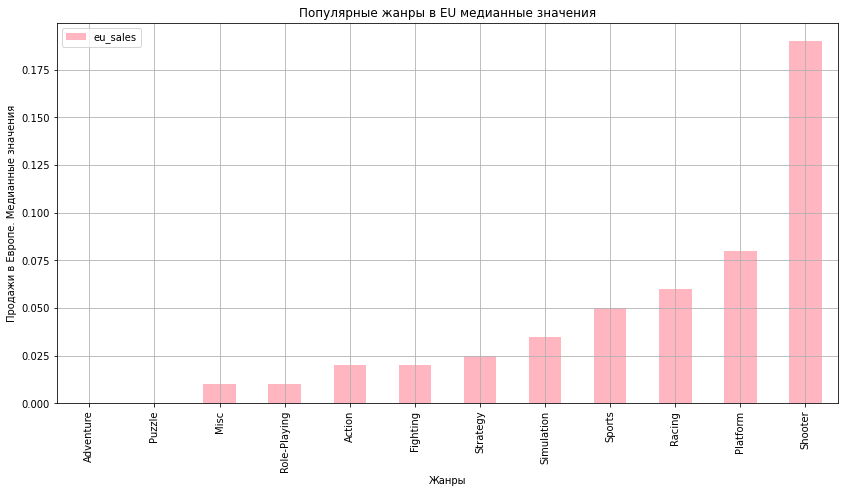

In [77]:
eu_user_platform = data_new.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales')
eu_user_platform_median = data_new.pivot_table(index='genre', values='eu_sales', aggfunc='median').sort_values(by='eu_sales')
eu_user_platform.plot(kind='bar', grid=True, figsize=(14, 7), title='Популярные жанры в EU', color='lightpink');
plt.xlabel('Жанры');
plt.ylabel('Продажи в Европе');
plt.show()

eu_user_platform_median.plot(kind='bar', grid=True, figsize=(14, 7), 
                             title='Популярные жанры в EU медианные значения', color='lightpink');
plt.xlabel('Жанры');
plt.ylabel('Продажи в Европе. Медианные значения');

Рассмотрим влияние рейтинга ESRB

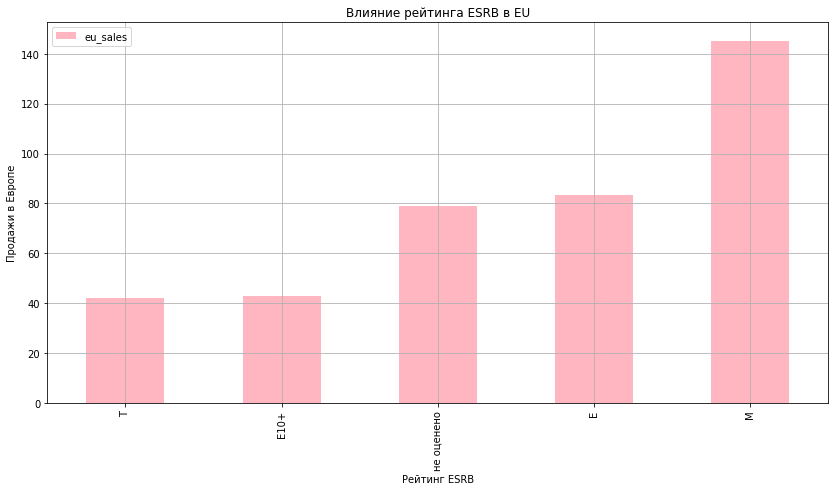

In [78]:
eu_user_platform = data_new.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales')
eu_user_platform.plot(kind='bar', grid=True, figsize=(14, 7), title='Влияние рейтинга ESRB в EU', color='lightpink');
plt.xlabel('Рейтинг ESRB');
plt.ylabel('Продажи в Европе');

В топ-5 платформ в Европе можно отнести следующие: PS4, PS3, XOne, X360, 3DS. По медианным продажам: Wii, DS, X360, PS4, Xone. В целом, по топу платформ ситуация в Европе схожа с Америкой - американские продукты имеют бОльшие продажи.

Наиболее 5 популярных жанров в Европе: action, shooter, sports, role-playing, racing. По медианным значениям больше всего прибыли приносят, как и в Америке, shooter.

Больше всего в Европе продоавлись игры с рейтингом M (старше 17 лет). На втором месте рейтинг Е (для всех возрастов) и почти с такими показателями игры с неопредленным рейтингом (тут причина может быть такая же, как в Америке + ESRB - американская компания, возможно, европейские страны используют какие-то свои рейтинговые организации) . 

    E10+ - подходит для лиц старше 10 лет;
    T - подходит для лиц старше 13 лет.


### Япония

Рассмотрим популярные платформы

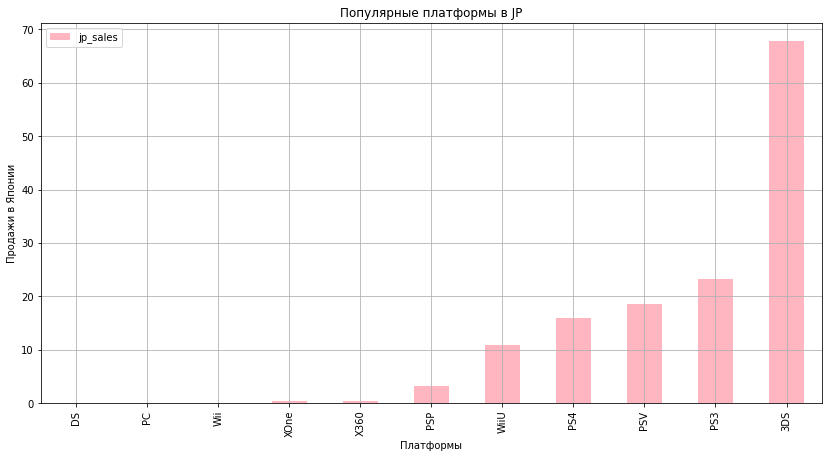

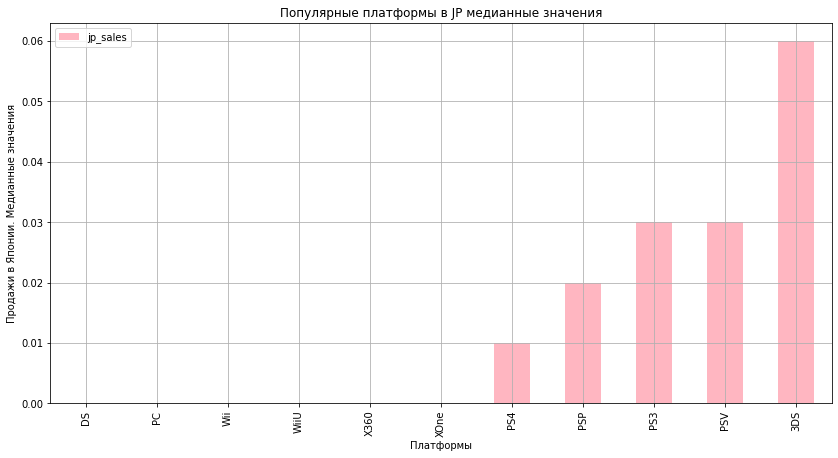

In [79]:
jp_user_platform = data_new.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales')
jp_user_platform_median = data_new.pivot_table(index='platform', values='jp_sales', aggfunc='median').sort_values(by='jp_sales')
jp_user_platform.plot(kind='bar', grid=True, figsize=(14, 7), title='Популярные платформы в JP', color='lightpink');
plt.xlabel('Платформы');
plt.ylabel('Продажи в Японии');
plt.show()

jp_user_platform_median.plot(kind='bar', grid=True, figsize=(14, 7), 
                             title='Популярные платформы в JP медианные значения', color='lightpink');
plt.xlabel('Платформы');
plt.ylabel('Продажи в Японии. Медианные значения');

Рассмотрим популярные жанры

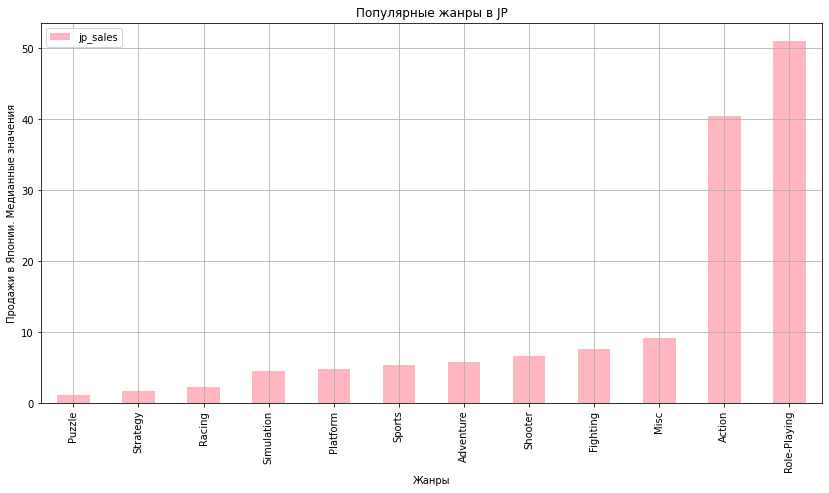

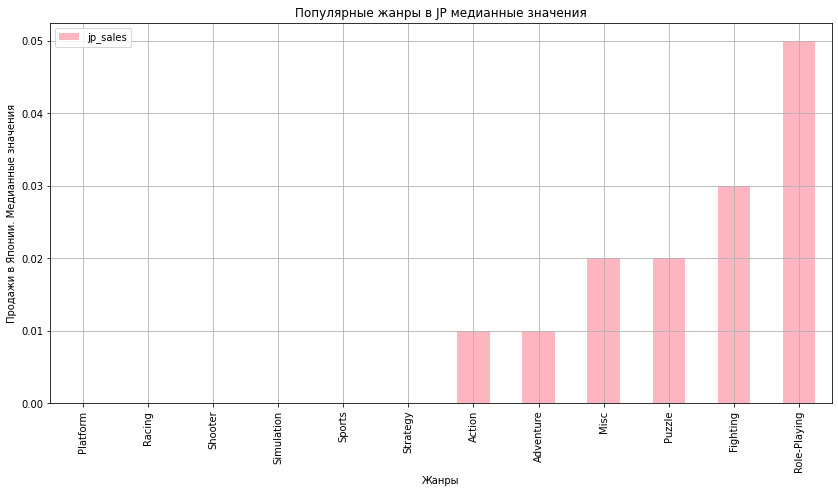

In [80]:
jp_user_platform = data_new.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales')
jp_user_platform_median = data_new.pivot_table(index='genre', values='jp_sales', aggfunc='median').sort_values(by='jp_sales')
jp_user_platform.plot(kind='bar', grid=True, figsize=(14, 7), title='Популярные жанры в JP', color='lightpink');
plt.xlabel('Жанры');
plt.ylabel('Продажи в Японии. Медианные значения');
plt.show()

jp_user_platform_median.plot(kind='bar', grid=True, figsize=(14, 7), 
                             title='Популярные жанры в JP медианные значения', color='lightpink');
plt.xlabel('Жанры');
plt.ylabel('Продажи в Японии. Медианные значения');

Рассмотрим влияние рейтинга ESRB

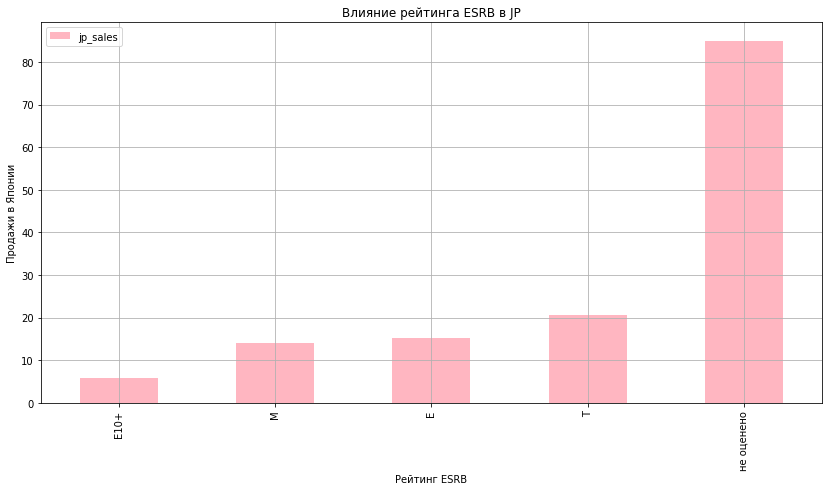

In [81]:
jp_user_platform = data_new.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales')
jp_user_platform.plot(kind='bar', grid=True, figsize=(14, 7), title='Влияние рейтинга ESRB в JP', color='lightpink');
plt.xlabel('Рейтинг ESRB');
plt.ylabel('Продажи в Японии');

В топ-5 платформ в Японии входят: 3DS, PS3, PSV, PS4, WiiU. По медианным данным: 3DS, PSV,PS3, PSP, PS4. Столь большая популярность платормы 3DS вызваны, вероятнее всего, тем, что это японская разработка.

Среди жанров наиболее популярны слелующие: role-playing, action, misc, foghting, shooter. По медианным данным больше всего приносит прибыли role-playing.

Среди продаваемых игр, чаще всего встречаются игры с рейтингом "не оценено". Это вызвано тем, что ESRB - американская компания, а в Японии существует свои рейтинговые орагнизации.

В общем выводе можно сказать, что наиболее популяными платформы являются 

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Гипотеза H0 - cредние пользовательские рейтинги платформ Xbox One и PC одинаковые

Альтернативная гипотеза H1 - cредние пользовательские рейтинги платформ Xbox One и PC разные

In [65]:
user_score_xone = data_new.dropna().query('platform == "XOne"') # данные с платформой XBox One
user_score_pc = data_new.dropna().query('platform == "PC"') # данные с платформой PC
#как выяснилось, с пропусками p-значение не считается, поэтому убрала их

In [66]:
alpha = 0.05 #возьмем стандартное значение

#это проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них 
#выборкам - поэтому используем st.ttest_ind

results = st.ttest_ind(
    user_score_xone['user_score'], 
    user_score_pc['user_score'],
    ) 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.17306926618147322
Не получилось отвергнуть нулевую гипотезу


In [67]:
print('Средняя оценка пользователей XBox One:', user_score_xone['user_score'].mean())
print('Средняя оценка пользователей PC:', user_score_pc['user_score'].mean())

Средняя оценка пользователей XBox One: 6.538181818181818
Средняя оценка пользователей PC: 6.3020270270270276


Результаты достаточно близки друг к другу, поэтому альтернативня гипотеза не принимается.

### Средние пользовательские рейтинги жанров Action и Sports разные.

Гипотеза H0 - cредние пользовательские рейтинги жанров Action и Sports одинаковые

Альтернативная гипотзеа H1 - cредние пользовательские рейтинги жанров Action и Sports разные

In [68]:
user_score_action = data_new.dropna().query('genre == "Action"')
user_score_sports = data_new.dropna().query('genre == "Sports"')

In [69]:
alpha = 0.05 

#это проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них 
#выборкам - поэтому тоже используем st.ttest_ind
results = st.ttest_ind(
    user_score_action['user_score'], 
    user_score_sports['user_score'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.684099430689953e-16
Отвергаем нулевую гипотезу


In [70]:
print('Средняя оценка пользователей жанра Action:', user_score_action['user_score'].mean())
print('Средняя оценка пользователей жанра Sports:', user_score_sports['user_score'].mean())

Средняя оценка пользователей жанра Action: 6.9362459546925574
Средняя оценка пользователей жанра Sports: 5.665454545454545


Нулевая гипотеза о том, что средние пользовательские рейтинги одинаковые, отвергается. Принимается альтернативная

При формулировке гипотез использовался подход, когда нулевой гипотезе противопосталяется альтернативная гипотеза. Т.е. гипотеза, противополложная ей по значению (или просто имеющаяя другой исход).

В качестве критерия использовался p-value - уровень значимости, на котором среднее значение и сравниваемое значение находятся друг от друга. Он позволяет получить вероятность наблюдаемого результата при условии, что нулевая гипотеза верна.

## Общий вывод

Для работы были представлены данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation), до 2016 года. Требовалось выявить определяющие успешность игры закономерности, что позволило бы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Вначале работы была проведена предобработка данных, в процесе которой был решен вопрос с пропусками, неверным типом данных и добавлен столбец с суммарными продажами.

Далее проводился исследовательский анализ.
Для дальнейшего анализа были взяты данные за последние пару лет - с 2013 года, чтобы выборка была наиболее акутальной. Индустрия компьютерных игр довольно быстро-развивающаяся отрасль, поэтому был взят такой небольшой промежуток.

Среди платформ была получена следующая закономерность: лидируют по продажам PS4, PS3 и Xone. При этом в Северной Америке в ТОП-3 популярных платформ вошли:  PS4, Xone, X360. В Европе: PS4, PS3, XOne. И в Японии: 3DS, PS3, PSV. В Америке и Европе более популярны американские платформы, а в Японии - японские.

Была проанализирована зависимость продаж от оценок критиков и пользователей. Как таковой зависимости между оценками критиков/пользователей и суммарными продажами - нет. Между продажами и оценками критиков корреляция больше, чем между продажами и пользовательскими оценками, но значения коэфициента колеблются от 0,3 до 0,4, что говорит о слабой связи.

Если говорить про жанры, то картина следующая: по суммарным продажам в ТОП-3 входят игры с жанрами: action, shooter и sports. При этом в Северной Америке наиболее популярны: action, shooter, sports. В Европе: action, shooter, sports. И в Японии: role-playing, action, misc. Опять же таки видно, что предпочтения европейцев и американцев разнятся с японскими.

Также стоит сказать про игровые рейтинги. В Америке больше всего продавались игры с рейтингом М (страше 17 лет). В Европе тоже лидируют игры с рейтингом М. А в Японии больше всего игр с "не оцененным" рейтингом. Япония использует свою рейтинговую организацию, поэтому, возможно, столько непоредленных значений.

Кроме этого, было выдвинуто несколько гипотез.
1) Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

    Эта гипотеза не была отвергнута, p-значение: 0.17, что больше уровня значимость альфа в 0,05.

    Средняя оценка пользователей платформы XBox One: 6.521428571428572

    Средняя оценка пользователей платформы PC: 6.269677419354839

2) Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

    Эта гипотеза подтвердилась - эти рейтинги дейсвтительно разные.

    Средняя оценка пользователей жанра Action: 6.9362459546925574

    Средняя оценка пользователей жанра Sports: 5.665454545454545
